<a href="https://colab.research.google.com/github/tcotte/CNN_Pytorch/blob/master/GradCam_CNNVisualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GradCam - Visualisation CNN

https://pypi.org/project/pytorch-gradcam/

In [ ]:
pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 6.4MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5268 sha256=dda0d92abc89798b6c8290e3e564d6071681b5fbb06dd83bbd37065d9e674f34
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [ ]:
!git clone https://github.com/tcotte/CNN_Pytorch.git

fatal: destination path 'CNN_Pytorch' already exists and is not an empty directory.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset

from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Infos
1. Using cats and dogs datasets (imageNet format)
2. Resnet50 model

## Load dataset

In [ ]:
#classes = {0: 'Cat', 1: 'Dog'}

In [ ]:
#reading the labels of data we uploaded
with open("/content/CNN_Pytorch/data/imagenet_labels.txt") as f:classes = eval(f.read())

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
transform_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
#define the data we uploaded as evaluation data and apply the transformations
imagefolder = "/content/CNN_Pytorch/data/CatVSDog/test"
evalset = torchvision.datasets.ImageFolder(root = imagefolder, transform = transform_norm)

In [ ]:
#create a data loader for evaluation

batch_size=1 #batch size
evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True)

In [ ]:
#looking at data using iter

dataiter = iter(evalloader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)
#shape of single image in a bunch
print(images[0].shape)

#label of the image
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
0


## Load pretrained model

In [ ]:
model = models.resnet50(pretrained=True)
#model =resnet.load_state_dict(torch.load("/content/CNN_Pytorch/resnet50_catsvsdogs.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Visualise image

In [ ]:
def imshow(img, title):
  
  """Custom function to display the image using matplotlib"""
  
  #define std correction to be made
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [ ]:
#custom function to fetch images from dataloader

def show_batch_images(dataloader):
  images,_ = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images)
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images)
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred

In [ ]:
print(evalloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


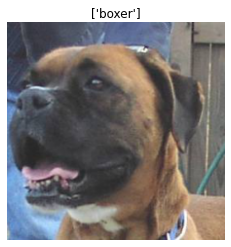

In [ ]:
images, pred = show_batch_images(evalloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


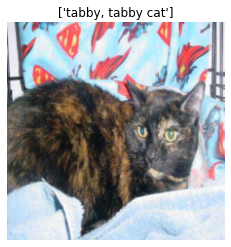

In [ ]:
images, labels = dataiter.next()
images, pred = show_batch_images(evalloader)

## Grad Cam analysis

In [ ]:
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [ ]:
configs = [
    dict(model_type='resnet', arch=resnet, layer_name='layer4')
]

In [ ]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

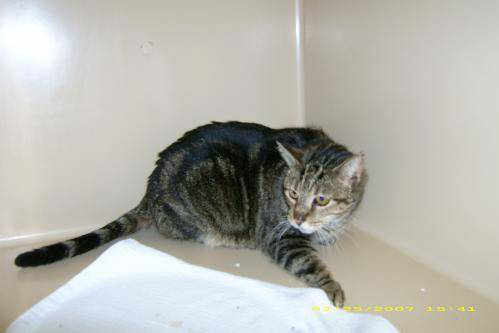

In [ ]:
import os
import PIL

img_dir = '/content/CNN_Pytorch/data/CatVSDog/test/test'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_name = '12302.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

In [ ]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [ ]:
#torch_img = 
#normed_torch_img = 

In [ ]:
cam_images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    cam_images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(cam_images, nrow=5)

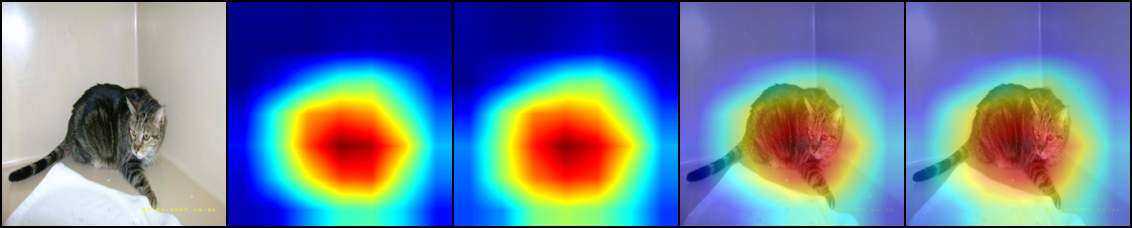

In [ ]:
transforms.ToPILImage()(grid_image)